In [9]:
# load special jupyter notebook helpers
%matplotlib inline

# import libraries we'll use below
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data
data_path = '/home/aca10131kr/datasets/01_eeg_fmri_data.h5'
with h5py.File(data_path, 'r') as f:
    eeg_data = np.array(f['eeg_train'][:])
    fmri_data = np.array(f['fmri_train'][:])

# Normalize the data
eeg_data = eeg_data / np.max(eeg_data)
fmri_data = fmri_data / np.max(fmri_data)

# Split the data into training and testing sets
eeg_train, eeg_test, fmri_train, fmri_test = train_test_split(eeg_data, fmri_data, test_size=0.2, random_state=42)

# Further normalize training and testing data
eeg_train = (eeg_train - np.min(eeg_train)) / (np.max(eeg_train) - np.min(eeg_train))
fmri_train = (fmri_train - np.min(fmri_train)) / (np.max(fmri_train) - np.min(fmri_train))
eeg_test = (eeg_test - np.min(eeg_test)) / (np.max(eeg_test) - np.min(eeg_test))
fmri_test = (fmri_test - np.min(fmri_test)) / (np.max(fmri_test) - np.min(fmri_test))

# Select a small subset of the data (e.g., 100 samples)
subset_size = 100
eeg_subset = eeg_train[:subset_size]
fmri_subset = fmri_train[:subset_size]

# Create a dataset class
class EEGfMRIDataset(Dataset):
    def __init__(self, eeg_data, fmri_data):
        self.eeg_data = eeg_data
        self.fmri_data = fmri_data

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx]
        fmri = self.fmri_data[idx]
        return eeg, fmri

# Create new dataset and dataloader for the subset
subset_dataset = EEGfMRIDataset(torch.tensor(eeg_subset, dtype=torch.float32), torch.tensor(fmri_subset, dtype=torch.float32))
subset_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True)


In [11]:
class ComplexConvAutoencoder(nn.Module):
    def __init__(self):
        super(ComplexConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=2, padding=1),  # (B, 64, 32, 135, 5)
            nn.ReLU(True),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, 16, 68, 3)
            nn.ReLU(True),
            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),  # (B, 256, 8, 34, 2)
            nn.ReLU(True),
            nn.Conv3d(256, 512, kernel_size=3, stride=2, padding=1),  # (B, 512, 4, 17, 1)
            nn.ReLU(True),
            nn.Conv3d(512, 1024, kernel_size=3, stride=2, padding=1), # (B, 1024, 2, 9, 1)
            nn.ReLU(True),
            nn.Dropout3d(0.5)  # Dropout layer
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 512, 4, 17, 1)
            nn.ReLU(True),
            nn.ConvTranspose3d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 256, 8, 34, 2)
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 128, 16, 68, 3)
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 32, 135, 5)
            nn.ReLU(True),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 1, 64, 270, 10)
            nn.Upsample(size=(64, 64, 30), mode='trilinear', align_corners=True),  # Ensure final output size matches
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)  # Change shape from (B, 64, 269, 10, 1) to (B, 1, 64, 269, 10)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ComplexConvAutoencoder().to(device)

In [16]:
# Define the loss function
criterion = nn.MSELoss()

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training loop
num_epochs = 2000  
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in subset_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Permute labels to match the shape of outputs
        labels = labels.permute(0, 4, 1, 2, 3)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    scheduler.step()  # Adjust learning rate

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(subset_loader):.4f}')

print('Finished Training')

Epoch [1/2000], Loss: 0.0624
Epoch [2/2000], Loss: 0.0625
Epoch [3/2000], Loss: 0.0624
Epoch [4/2000], Loss: 0.0624
Epoch [5/2000], Loss: 0.0625
Epoch [6/2000], Loss: 0.0625
Epoch [7/2000], Loss: 0.0624
Epoch [8/2000], Loss: 0.0623
Epoch [9/2000], Loss: 0.0617
Epoch [10/2000], Loss: 0.0551
Epoch [11/2000], Loss: 0.0368
Epoch [12/2000], Loss: 0.0263
Epoch [13/2000], Loss: 0.0214
Epoch [14/2000], Loss: 0.0179
Epoch [15/2000], Loss: 0.0157
Epoch [16/2000], Loss: 0.0142
Epoch [17/2000], Loss: 0.0133
Epoch [18/2000], Loss: 0.0128
Epoch [19/2000], Loss: 0.0121
Epoch [20/2000], Loss: 0.0121
Epoch [21/2000], Loss: 0.0118
Epoch [22/2000], Loss: 0.0115
Epoch [23/2000], Loss: 0.0115
Epoch [24/2000], Loss: 0.0112
Epoch [25/2000], Loss: 0.0112
Epoch [26/2000], Loss: 0.0110
Epoch [27/2000], Loss: 0.0110
Epoch [28/2000], Loss: 0.0106
Epoch [29/2000], Loss: 0.0107
Epoch [30/2000], Loss: 0.0109
Epoch [31/2000], Loss: 0.0108
Epoch [32/2000], Loss: 0.0105
Epoch [33/2000], Loss: 0.0105
Epoch [34/2000], Lo

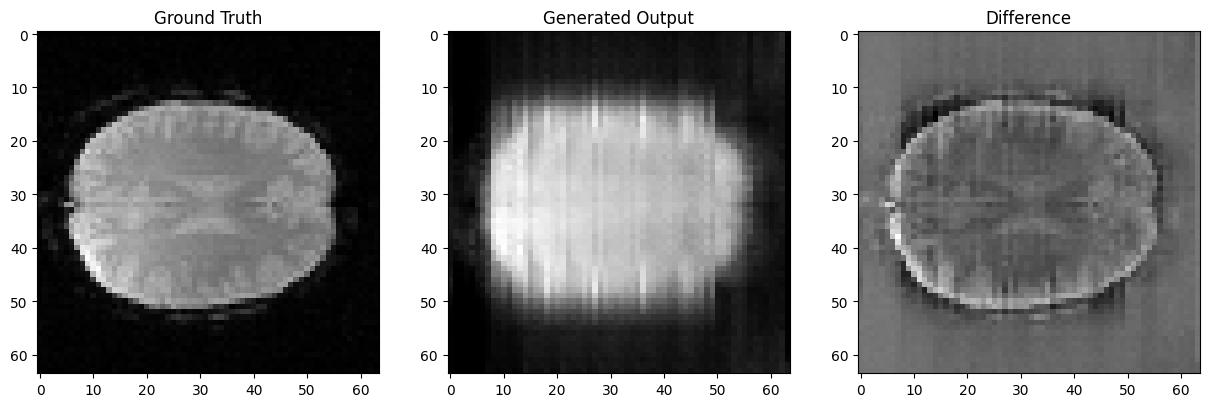

In [17]:
# Put the model in evaluation mode
model.eval()

# Get a batch of test inputs
test_batch = next(iter(test_loader))
inputs, labels = test_batch
inputs, labels = inputs.to(device), labels.to(device)

# Generate outputs
with torch.no_grad():
    outputs = model(inputs)

# Convert to NumPy arrays
inputs_np = inputs.cpu().numpy()
labels_np = labels.cpu().numpy()
outputs_np = outputs.cpu().numpy()

# Permute labels to match the shape of outputs
labels_np = np.transpose(labels_np, (0, 4, 1, 2, 3))

# Function to plot the data
def plot_comparison(labels, outputs, slice_idx, depth_idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Select a specific depth slice
    labels_slice = labels[slice_idx, 0, :, :, depth_idx]
    outputs_slice = outputs[slice_idx, 0, :, :, depth_idx]
    diff_slice = labels_slice - outputs_slice

    # Ensure the selected slices are 2D
    labels_slice = labels_slice if labels_slice.ndim == 2 else labels_slice[:, :, 0]
    outputs_slice = outputs_slice if outputs_slice.ndim == 2 else outputs_slice[:, :, 0]
    diff_slice = diff_slice if diff_slice.ndim == 2 else diff_slice[:, :, 0]

    axes[0].imshow(labels_slice, cmap='gray')
    axes[0].set_title('Ground Truth')

    axes[1].imshow(outputs_slice, cmap='gray')
    axes[1].set_title('Generated Output')

    axes[2].imshow(diff_slice, cmap='gray')
    axes[2].set_title('Difference')

    plt.show()

# Plot a comparison for a specific slice and depth
plot_comparison(labels_np, outputs_np, slice_idx=0, depth_idx=16)


In [18]:
# Function to plot the data
def plot_comparison(labels, outputs, slice_idx):
    for depth_idx in range(17):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Select a specific depth slice
        labels_slice = labels[slice_idx, 0, :, :, depth_idx]
        outputs_slice = outputs[slice_idx, 0, :, :, depth_idx]
        diff_slice = labels_slice - outputs_slice

        # Ensure the selected slices are 2D
        labels_slice = labels_slice if labels_slice.ndim == 2 else labels_slice[:, :, 0]
        outputs_slice = outputs_slice if outputs_slice.ndim == 2 else outputs_slice[:, :, 0]
        diff_slice = diff_slice if diff_slice.ndim == 2 else diff_slice[:, :, 0]

        axes[0].imshow(labels_slice, cmap='gray')
        axes[0].set_title('Ground Truth')

        axes[1].imshow(outputs_slice, cmap='gray')
        axes[1].set_title('Generated Output')

        axes[2].imshow(diff_slice, cmap='gray')
        axes[2].set_title('Difference')

        plt.suptitle(f'Depth Index: {depth_idx}')
        plt.show()

# Plot a comparison for a specific slice and all depths in range 16
# plot_comparison(labels_np, outputs_np, slice_idx=0)


In [19]:
!nvidia-smi

Wed Jun 26 14:25:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   43C    P0    66W / 300W |   5245MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------